In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [4]:
df= pd.read_csv('./Data/3_Employee_rentation/Employee_Rentation.csv')
df.head()

,Unnamed: 0,employee_id,company_id,dept,seniority,salary,join_date,quit_date
0,1,13021.0,7,customer_service,28,89000.0,2014-03-24,2015-10-30
1,2,825355.0,7,marketing,20,183000.0,2013-04-29,2014-04-04
2,3,927315.0,4,marketing,14,101000.0,2014-10-13,NaN
3,4,662910.0,7,customer_service,20,115000.0,2012-05-14,2013-06-07
4,5,256971.0,2,data_science,23,276000.0,2011-10-17,2014-08-22


In [5]:
df.drop('Unnamed: 0', axis=1, inplace=True)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24702 entries, 0 to 24701
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   employee_id  24702 non-null  float64
 1   company_id   24702 non-null  int64  
 2   dept         24702 non-null  object 
 3   seniority    24702 non-null  int64  
 4   salary       24702 non-null  float64
 5   join_date    24702 non-null  object 
 6   quit_date    13510 non-null  object 
dtypes: float64(2), int64(2), object(3)
memory usage: 1.3+ MB


In [7]:
#parse date
df[['join_date', 'quit_date']] = df[['join_date', 'quit_date']].apply(pd.to_datetime)

# Q1
Assume, for each company, that the headcount starts from zero on 2011/01/23. Estimate employee headcount, for each company, on each day, from 2011/01/24 to 2015/12/13. That is, if by 2012/03/02 2000 people have joined company 1 and 1000 of them have already quit, then company headcount on 2012/03/02 for company 1 would be 1000.You should create a table with 3 columns: day, employee_headcount, company_id.

In [8]:
# create a new table with day, employee_headcount, and company_id
# unique dates table
dates = pd.date_range(start='2011/01/24', end='2015/12/13', freq='D')
dates = pd.DataFrame(dates, columns=['date'])
company = sorted(df['company_id'].unique())
company = pd.DataFrame(company, columns=['company_id'])
# cross join unique dates and company
dates_company = pd.merge(dates, company, how='cross')

# employee headcount table
join_date = df.groupby(['join_date', 'company_id']).size().reset_index()
join_date.columns=['date', 'company_id', 'join']
quit_date = df.groupby(['quit_date', 'company_id']).size().reset_index()
quit_date.columns=['date', 'company_id', 'quit']

headcount = pd.merge(dates_company, join_date, left_on=['date', 'company_id'], right_on=['date', 'company_id'], how='left')
headcount = pd.merge(headcount, quit_date, left_on=['date', 'company_id'], right_on=['date', 'company_id'], how='left')
headcount['join'].fillna(0, inplace=True)
headcount['quit'].fillna(0, inplace=True)
headcount['join_sum'] = headcount.groupby(['company_id'])['join'].cumsum()
headcount['quit_sum'] = headcount.groupby(['company_id'])['quit'].cumsum()
headcount['headcount'] = (headcount['join_sum'] - headcount['quit_sum']).astype(int)
headcount.drop(['join', 'quit', 'join_sum', 'quit_sum'], axis=1, inplace=True)
headcount


,date,company_id,headcount
0,2011-01-24,1,25
1,2011-01-24,2,17
2,2011-01-24,3,9
3,2011-01-24,4,12
4,2011-01-24,5,5
...,...,...,...
21415,2015-12-13,8,468
21416,2015-12-13,9,432
21417,2015-12-13,10,385
21418,2015-12-13,11,4


In [9]:
# create a new table with day, employee_headcount, and company_id using for loop
dates = pd.date_range(start='2011/01/24', end='2015/12/13', freq='D')
company = sorted(df['company_id'].unique())
day = []
company_id = []
headcount = []

for date in dates:
    for c in company:
        day.append(date)
        company_id.append(c)
        join_count = len(df.query('join_date<=@date and company_id==@c'))
        quit_count = len(df.query('quit_date<=@date and company_id==@c'))
        headcount.append(join_count - quit_count)
df_headcount = pd.DataFrame({'date':day, 'company_id':company_id, 'headcount':headcount})
df_headcount


,date,company_id,headcount
0,2011-01-24,1,25
1,2011-01-24,2,17
2,2011-01-24,3,9
3,2011-01-24,4,12
4,2011-01-24,5,5
...,...,...,...
21415,2015-12-13,8,468
21416,2015-12-13,9,432
21417,2015-12-13,10,385
21418,2015-12-13,11,4


# Employee Churn Analysis

## Q2
What are the main factors that drive employee churn? Do they make sense? Explain your findings.

In [10]:
#separate the stay and quit employees into two tables
df_stay = df.query('quit_date.isnull()')
df_quit = df.query('quit_date.notnull()')
df_stay.shape, df_quit.shape

((11192, 7), (13510, 7))

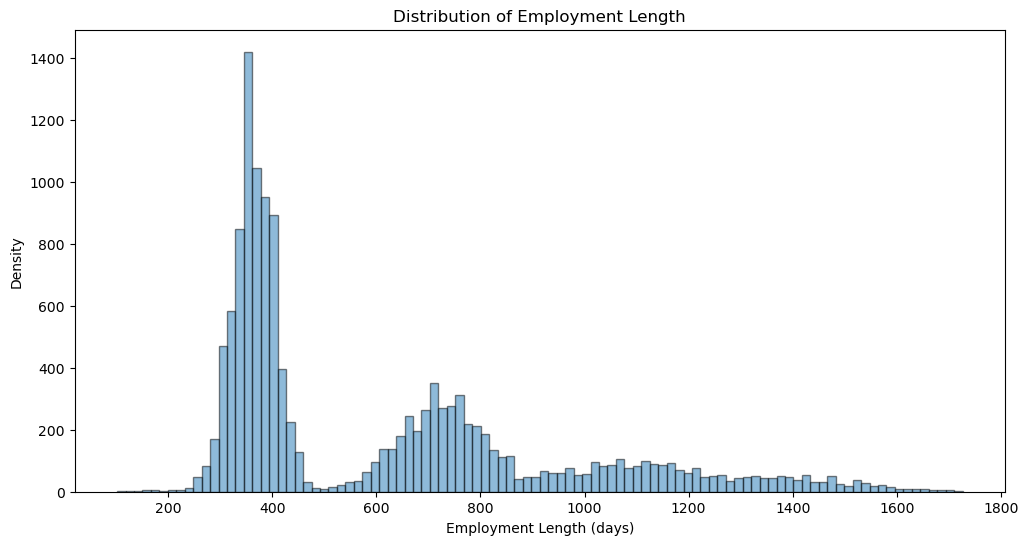

There are peaks around each employee anniversary!


In [11]:
# employment length
df_quit['work_length'] = (df_quit['quit_date'] - df_quit['join_date']).dt.days
plt.figure(figsize=(12,6))
hist_kws={'alpha':0.5, 'edgecolor':'black'}
sns.distplot(df_quit['work_length'], bins=100, kde=False, hist_kws=hist_kws)
plt.title('Distribution of Employment Length')
plt.xlabel('Employment Length (days)')
plt.ylabel('Density')
plt.show()

print('There are peaks around each employee anniversary!')

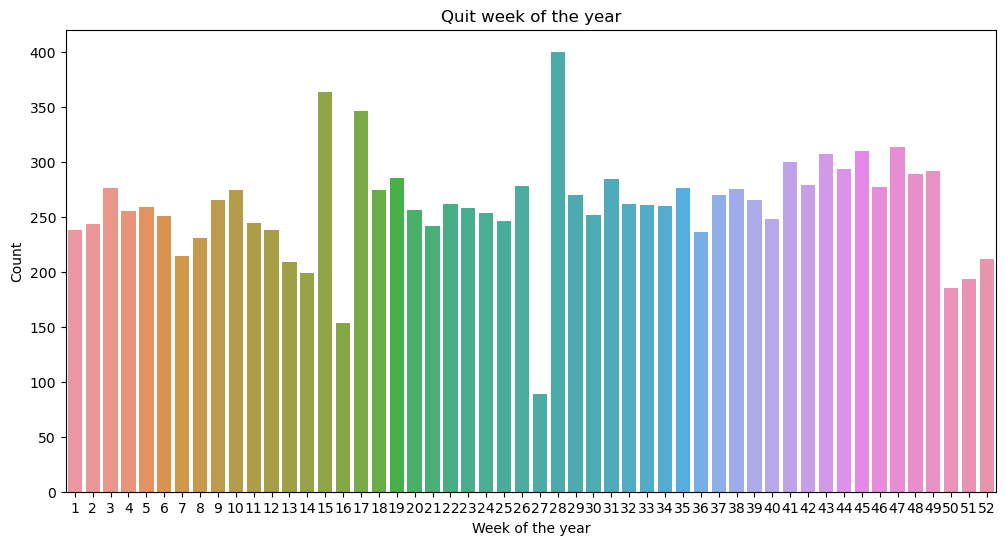

In [12]:
# Week of the year for quit date
df_quit['quit_week'] = df_quit['quit_date'].dt.week
plt.figure(figsize=(12,6))
sns.countplot(x='quit_week', data=df_quit)
plt.title('Quit week of the year')
plt.xlabel('Week of the year')
plt.ylabel('Count')
plt.show()


In [13]:
# feature engineer a binary variable for early quitters who quit within 13 months

# get the subset of employees who joined at least 13 months before 2015-12-13
stop_date = pd.to_datetime('2015-12-13') - pd.DateOffset(months=13)
df_subset = df[df['join_date']<stop_date]

# create a new binary class column for early quitters
df_subset['work_length'] = (df_subset['quit_date'] - df_subset['join_date']).dt.days
df_subset['early_quitter'] = df_subset['work_length'].apply(lambda x: 1 if x is not np.nan and x<=(365+31) else 0)

df_subset


,employee_id,company_id,dept,seniority,salary,join_date,quit_date,work_length,early_quitter
0,13021.0,7,customer_service,28,89000.0,2014-03-24,2015-10-30,585.0,0
1,825355.0,7,marketing,20,183000.0,2013-04-29,2014-04-04,340.0,1
2,927315.0,4,marketing,14,101000.0,2014-10-13,NaT,NaN,0
3,662910.0,7,customer_service,20,115000.0,2012-05-14,2013-06-07,389.0,1
4,256971.0,2,data_science,23,276000.0,2011-10-17,2014-08-22,1040.0,0
...,...,...,...,...,...,...,...,...,...
24695,63273.0,1,data_science,5,172000.0,2012-05-01,2015-06-26,1151.0,0
24696,94644.0,6,marketing,7,88000.0,2012-01-26,2013-02-01,372.0,1
24699,777612.0,4,customer_service,11,67000.0,2013-09-03,2015-10-23,780.0,0
24700,97289.0,10,engineer,98,266000.0,2011-12-13,2015-01-09,1123.0,0


In [14]:
# label encoding for categorical variables
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df_subset['dept'] = le.fit_transform(df_subset['dept'])

train_X = df_subset[['company_id', 'dept', 'seniority', 'salary']]
train_y = df_subset['early_quitter']
train_X


,company_id,dept,seniority,salary
0,7,0,28,89000.0
1,7,4,20,183000.0
2,4,4,14,101000.0
3,7,0,20,115000.0
4,2,1,23,276000.0
...,...,...,...,...
24695,1,1,5,172000.0
24696,6,4,7,88000.0
24699,4,0,11,67000.0
24700,10,3,98,266000.0


In [15]:
# build a decision tree model
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier(max_depth=3, min_samples_leaf=30, random_state=42)
clf.fit(train_X, train_y)

DecisionTreeClassifier(max_depth=3, min_samples_leaf=30, random_state=42)

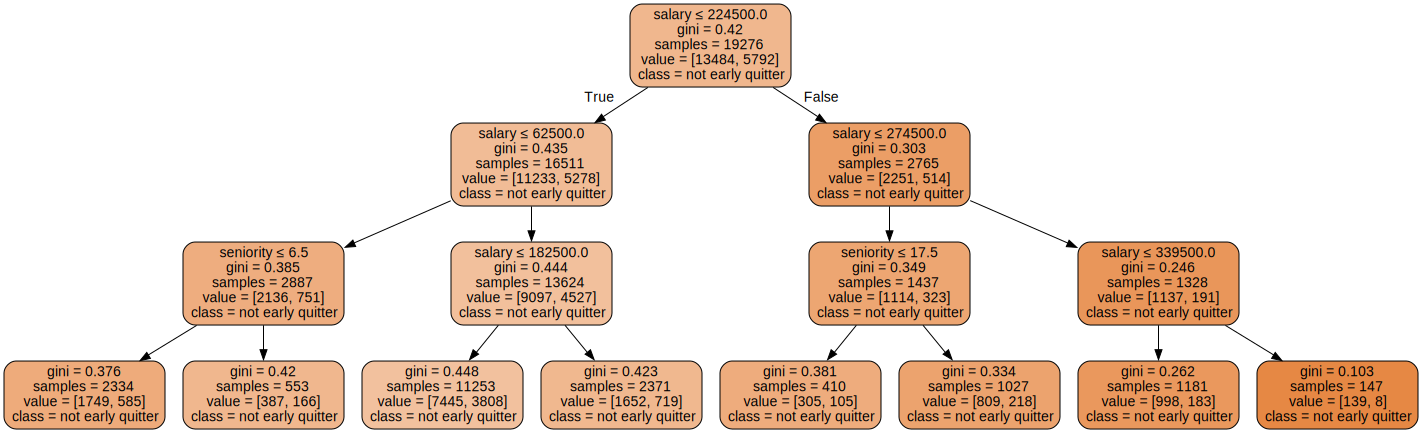

In [16]:
# visualize the decision tree
from sklearn.tree import export_graphviz
import graphviz
features = train_X.columns
target = ['not early quitter', 'early quitter']
dot_data = export_graphviz(clf, out_file=None, feature_names=features, class_names=target, filled=True, rounded=True, special_characters=True)
graph = graphviz.Source(dot_data)
graph

In [20]:
# check the feature importance
pd.DataFrame({'feature':features, 'importance':clf.feature_importances_})


,feature,importance
0,company_id,0.000000
1,dept,0.000000
2,seniority,0.025655
3,salary,0.974345


The most important feature is salary. 

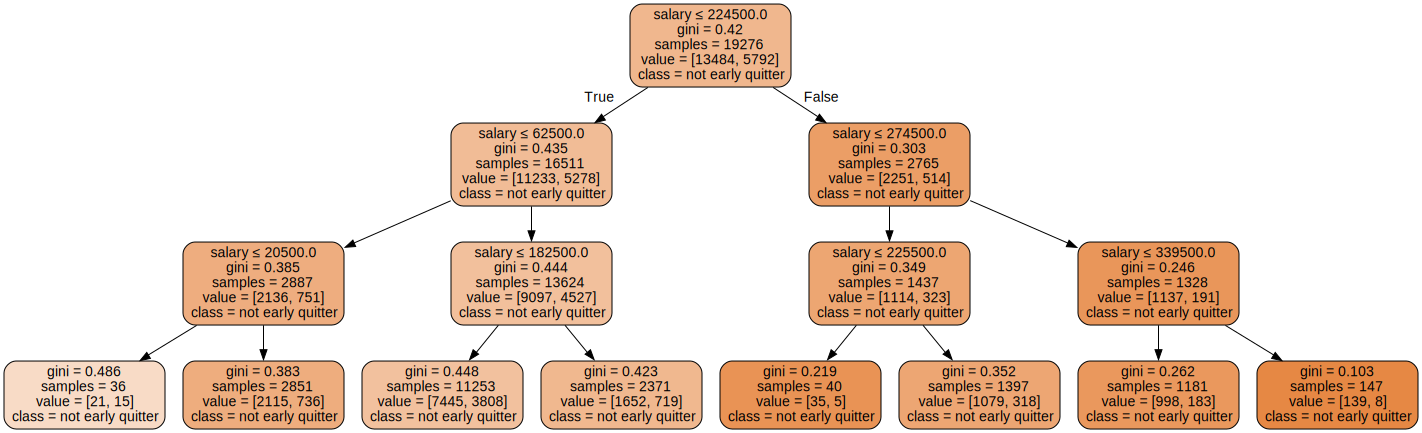

In [22]:
train_X = df_subset[['salary']]
train_y = df_subset['early_quitter']
clf_2 = DecisionTreeClassifier(max_depth=3, min_samples_leaf=30, random_state=42)
clf_2.fit(train_X, train_y)
dot_data_2 = export_graphviz(clf_2, out_file=None, feature_names=['salary'], class_names=target, filled=True, rounded=True, special_characters=True)
graph_2 = graphviz.Source(dot_data_2)
graph_2



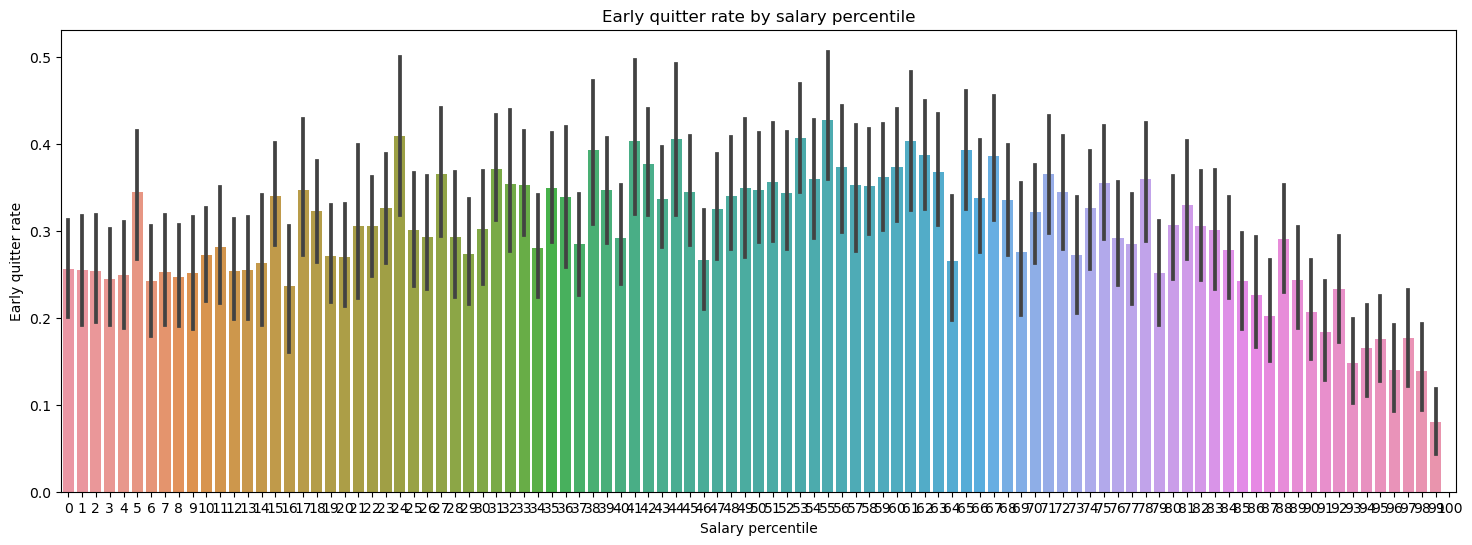

,employee_id,company_id,dept,seniority,salary,join_date,quit_date,work_length,early_quitter,salary_percentile
0,13021.0,7,0,28,89000.0,2014-03-24,2015-10-30,585.0,0,30
1,825355.0,7,4,20,183000.0,2013-04-29,2014-04-04,340.0,1,73
2,927315.0,4,4,14,101000.0,2014-10-13,NaT,NaN,0,37
3,662910.0,7,0,20,115000.0,2012-05-14,2013-06-07,389.0,1,45
4,256971.0,2,1,23,276000.0,2011-10-17,2014-08-22,1040.0,0,93
...,...,...,...,...,...,...,...,...,...,...
24695,63273.0,1,1,5,172000.0,2012-05-01,2015-06-26,1151.0,0,69
24696,94644.0,6,4,7,88000.0,2012-01-26,2013-02-01,372.0,1,29
24699,777612.0,4,0,11,67000.0,2013-09-03,2015-10-23,780.0,0,18
24700,97289.0,10,3,98,266000.0,2011-12-13,2015-01-09,1123.0,0,92


In [29]:
# plot the early quitter rate by salary percentile
df_subset['salary_percentile'] = df_subset['salary'].rank(pct=True)
df_subset['salary_percentile'] = df_subset['salary_percentile'].apply(lambda x: int(x*100))

plt.figure(figsize=(18,6))
sns.barplot(x='salary_percentile', y='early_quitter', data=df_subset, )
plt.title('Early quitter rate by salary percentile')
plt.xlabel('Salary percentile')
plt.ylabel('Early quitter rate')
plt.show()
df_subset

# Conclusion
- Given how important is salary, I would definitely love to have as a variable the salary the employee who quit was offered in the next job. Otherwise, things like: promotions or raises received during the employee tenure would be interesting.

- The major findings are that employees quit at year anniversaries or at the beginning of the year. Both cases make sense. Even if you don’t like your current job, you often stay for 1 yr before quitting + you often get stocks after 1 yr so it makes sense to wait. Also, the beginning of the year is well known to be the best time to change job: companies are hiring more and you often want to stay until end of Dec to get the calendar year bonus.

- Employees with low and high salaries are less likely to quit. Probably because employees with high salaries are happy there and employees with low salaries are not that marketable, so they have a hard time finding a new job.